In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import copy
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
normal_data_path = 'Adversarial_traffic_None.csv'
attack_data_path = 'Adversarial_traffic_Both.csv'

In [3]:
benign_data = pd.read_csv(normal_data_path)

In [4]:
benign_data.rename(columns={"TS" : "Timestamp"}, inplace=True)
benign_data.head()

,Timestamp,ID,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,Label
0,0.000000,000,8,00,00,00,00,00,00,00,00,1
1,0.005460,000,8,00,00,00,00,00,00,00,00,1
2,0.011176,140,8,00,00,00,00,1c,07,26,28,0
3,0.016722,000,8,00,00,00,00,00,00,00,00,1
4,0.016960,316,8,05,21,74,09,21,20,00,6f,0


In [5]:
def data_len(df):
    if 'Timestamp' in df.columns:
        # Ensure the Timestamp column is sorted
        df = df.sort_values(by='Timestamp')
        
        # Compute time difference
        time_diff = df['Timestamp'].iloc[-1] - df['Timestamp'].iloc[0]
        
        # Convert to HH:MM:SS:Milliseconds format
        hours, remainder = divmod(time_diff, 3600)
        minutes, remainder = divmod(remainder, 60)
        seconds, milliseconds = divmod(remainder, 1)
        
        time_str = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}:{int(milliseconds * 1000):03}"
        
        return time_str
    else:
        return "Timestamp column not found in dataframe"

In [6]:
attack_data = pd.read_csv(attack_data_path)
attack_data['Label'].replace({2:1, 3:1}, inplace=True)

In [ ]:
def construct_payload(row):
    dlc = int(row["DLC"])  # Number of valid data columns
    data_values = [row[f"Data{i}"] for i in range(1, dlc + 1) if f"Data{i}" in row]
    return "".join(map(str, data_values))

benign_data["Payload"] = benign_data.apply(construct_payload, axis=1)
attack_data["Payload"] = attack_data.apply(construct_payload, axis=1)
# Keep only the required columns
benign_data = benign_data[["Timestamp", "ID", "DLC", "Payload", "Label"]]
attack_data = attack_data[["TS", "ID", "DLC", "Payload", "Label"]]
## Rename the columns to Timestamp, ID, DLC, Data, and Label
attack_data.columns = ["Timestamp", "ID", "DLC", "Payload", "label"]

# Save the transformed data
# data.to_csv("transformed_file.csv", index=False)

# Display the transformed DataFrame

attack_data.head()

,Timestamp,ID,DLC,Payload,label
0,0.000000,2fb,8,de3de7fc77d18619,1
1,0.005492,643,8,de5f417c9b4d34db,1
2,0.011240,140,8,000000001c072628,0
3,0.016786,6df,8,05b06567dfdff49d,1
4,0.017052,316,8,052174092120006f,0


In [8]:
benign_data

,Timestamp,ID,DLC,Payload,Label
0,0.000000,000,8,0000000000000000,1
1,0.005460,000,8,0000000000000000,1
2,0.011176,140,8,000000001c072628,0
3,0.016722,000,8,0000000000000000,1
4,0.016960,316,8,052174092120006f,0
...,...,...,...,...,...
72754,68.506834,18f,8,fe58000000410000,0
72755,68.507064,260,8,1a222230088f6d04,0
72756,68.507300,2a0,8,04009a1d9702bd00,0
72757,68.507536,329,8,40b67f1411200014,0


In [9]:
print(f" Length of benign data: {data_len(benign_data)}")
print(f" Length of attack data: {data_len(attack_data)}")

 Length of benign data: 00:01:08:507
 Length of attack data: 00:01:06:877


In [10]:
hex_to_dec = lambda x: int(str(x), 16) if isinstance(x, str) else x

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)

    return data

# Function to handle conversion
def convert_hex_column(column):
    def convert_value(value):
        try:
            # Try to convert using hex_to_dec
            return hex_to_dec(value)
        except ValueError:
            # If ValueError occurs, it means the value is in scientific notation
            return int(float(value))
    
    return column.apply(convert_value)


benign_data = transform_data(benign_data)
attack_data = transform_data(attack_data)

In [11]:
data_len(benign_data)

'00:01:08:507'

In [12]:
train_data, val_data = train_test_split(benign_data, test_size=0.8, shuffle=False)

In [13]:
train_data

,Timestamp,ID,DLC,Payload,Label
0,0.000000,0,8,0,1
1,0.005460,0,8,0,1
2,0.011176,320,8,470230568,0
3,0.016722,0,8,0,1
4,0.016960,790,8,369704226980364399,0
...,...,...,...,...,...
14546,17.818404,1088,8,18374686483962333184,0
14547,17.818646,1349,8,15564440866243215360,0
14548,17.818888,1264,8,549762748691,0
14549,17.819834,704,8,1441151880758558720,0


In [14]:
def create_transition_matrix(data):

    start_time = time.time() 

    id_list = data['ID'].to_list()

    unique_ids = list(set(id_list))

    print(f"There are {len(unique_ids)} unique keys in this dataset")

    transition_matrix = {key : [False] * len(unique_ids) for key in unique_ids}

    for i in tqdm(range(len(id_list) - 1)):
        ##Extracting ID pair to check in transition matrix
        first_id = id_list[i]
        second_id = id_list[i+1]

        if transition_matrix[first_id][unique_ids.index(second_id)]:
            continue
        else:
            transition_matrix[first_id][unique_ids.index(second_id)] = True

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"Function execution time for dataset with {len(id_list)} items : {execution_time:.4f} seconds")

    return transition_matrix, unique_ids

ch_tm, ch_unique_ids = create_transition_matrix(train_data)

There are 27 unique keys in this dataset


100%|██████████| 14550/14550 [00:00<00:00, 3297872.10it/s]

Function execution time for dataset with 14551 items : 0.0646 seconds


In [15]:
# ch_val_tm, ch_val_unique_ids = create_transition_matrix(val_data)

In [16]:
def validation(val_data, transition_matrix, unique_ids):

    """
        val_data : validation data 
        transition_matrix: transition matrix
        unique_ids: list of unique ids in training data
    """
    
    ##SHOULD I MAKE IT MORE EFFICIENT BY DOING ID verification first?


    start_time = time.time() 

    fpr_count = 0

    keys = transition_matrix.keys()

    val_data_ids = val_data['ID'].to_list()

    for i in tqdm(range(len(val_data_ids) - 1)):

        first_id = val_data_ids[i]
        second_id = val_data_ids[i+1]

        ## Check if both keys are in transition matrix

        if (first_id in list(keys)) and (second_id in list(keys)):

            ##Check if transition is valid
            if transition_matrix[first_id][unique_ids.index(second_id)]:
                continue
            else: 
                ## If not valid, then increase False Positive Rate Count, and update the matrix
                fpr_count += 1
                transition_matrix[first_id][unique_ids.index(second_id)] = True
        
        else:
            raise ValueError(f"{first_id} or {second_id} ID Not Found, Exiting Validation Process")
            
    
    ## Calculate False Positive Rate
    fpr = fpr_count / len(val_data_ids)
    print(f"False Positive Rate: {fpr:.4f}")
        
    end_time = time.time()
    execution_time = end_time - start_time


    print(f"Function execution time for dataset with {len(val_data_ids)} items : {execution_time:.4f} seconds")

    return transition_matrix

In [17]:
validated_ch_tm = copy.deepcopy(ch_tm)
validated_ch_tm = validation(val_data, validated_ch_tm, ch_unique_ids)

100%|██████████| 58207/58207 [00:00<00:00, 1174089.65it/s]

False Positive Rate: 0.0018
Function execution time for dataset with 58208 items : 0.0844 seconds


In [18]:
def visualize_dict_as_matrix(data_dict, plot_title = None, cell_size=20, grid_color='black', grid_width=1):
    """
    Convert a dictionary with boolean lists into a visual matrix image.
    
    Parameters:
    - data_dict: Dictionary where each value is a list of boolean values
    - cell_size: Size of each cell in pixels (higher value = higher resolution)
    - grid_color: Color of the grid lines
    - grid_width: Width of the grid lines
    
    Returns:
    - Displays and saves the matrix visualization
    """
    # Verify all lists are the same length and match the number of keys
    keys = list(data_dict.keys())
    n = len(keys)
    if any(len(data_dict[key]) != n for key in keys):
        raise ValueError("All lists must have the same length as the number of keys")

    # Create an n×n matrix filled with boolean values from the dictionary
    matrix = np.zeros((n, n), dtype=bool)
    
    # Fill the matrix with values from the dictionary
    for i, key in enumerate(keys):
        matrix[i] = data_dict[key]
    
    # Calculate figure size and resolution
    figsize = (n * cell_size / 100, n * cell_size / 100)
    dpi = 100
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Create the heatmap (red for False, green for True)
    cmap = plt.matplotlib.colors.ListedColormap(['red', 'green'])
    
    # Plot the matrix
    im = ax.imshow(matrix, cmap=cmap, interpolation='none')
    
    # Add grid lines
    for i in range(n+1):
        ax.axhline(i-0.5, color=grid_color, linewidth=grid_width)
        ax.axvline(i-0.5, color=grid_color, linewidth=grid_width)
    
    # Remove ticks but keep labels if needed
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(keys)
    ax.set_yticklabels(keys)
    
    # Set title and labels
    if plot_title:
        ax.set_title(plot_title)
    
    # Optional: customize tick parameters
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    # plt.savefig('matrix_visualization.png', bbox_inches='tight', dpi=dpi*2)
    
    # Display the figure
    plt.show()
    
    return fig, ax

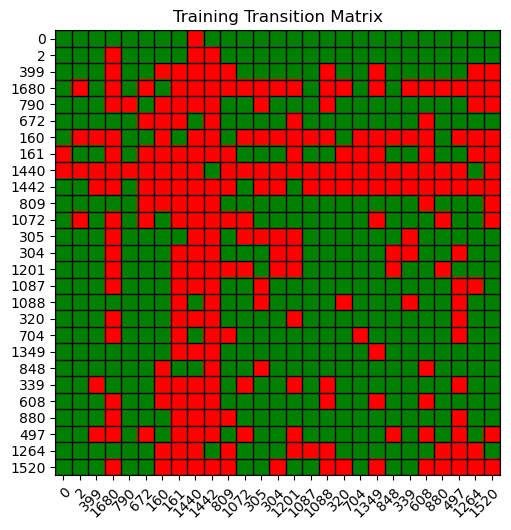

(<Figure size 540x540 with 1 Axes>,
 <Axes: title={'center': 'Training Transition Matrix'}>)

In [19]:
visualize_dict_as_matrix(ch_tm, "Training Transition Matrix")

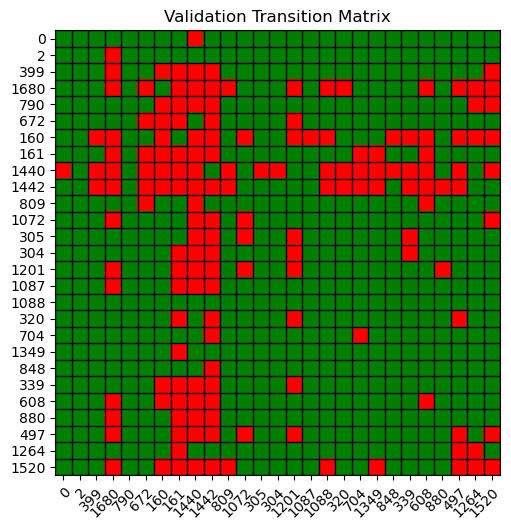

(<Figure size 540x540 with 1 Axes>,
 <Axes: title={'center': 'Validation Transition Matrix'}>)

In [20]:
visualize_dict_as_matrix(validated_ch_tm, "Validation Transition Matrix")

In [21]:
def shift_columns(df):
    
    for dlc in [2,5,6]:

        df.loc[df['DLC'] == dlc, df.columns[3:]] = df.loc[df['DLC'] == dlc, df.columns[3:]].shift(periods=8-dlc, axis='columns', fill_value='00')

    return df

def read_ch_data(data_path):
    
    columns = ['Timestamp','ID', 'DLC', 'data0', 'data1', 'data2', 'data3', 'data4', 
           'data5', 'data6', 'data7', 'label']
    
    data = pd.read_csv(data_path, names = columns)

    data = shift_columns(data)
    
    ##Replacing all NaNs with '00' 
    data = data.replace(np.NaN, '00')
    
    ##Joining all data columns to put all data in one column
    data_cols = ['data0', 'data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7']
    
    ##The data column is in hexadecimal
    data['Payload'] = data[data_cols].apply(''.join, axis=1)
    data.drop(columns = data_cols, inplace = True, axis = 1)
        
    data = data.assign(IAT=data['Timestamp'].diff().fillna(0))
    data = data[['Timestamp', 'ID','DLC','Payload', 'IAT', 'label']]
    data['label'].replace({'R' : 0, 'T' : 1}, inplace = True)
    
    return data

100%|██████████| 80500/80500 [00:00<00:00, 382737.52it/s]


              precision    recall  f1-score   support

      Normal       0.82      1.00      0.90     60576
      Attack       1.00      0.31      0.48     19925

    accuracy                           0.83     80501
   macro avg       0.91      0.66      0.69     80501
weighted avg       0.86      0.83      0.79     80501

Accuracy: 0.8296
F1 Score: 0.4752
True Positive Rate (TPR / Recall): 0.3117
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.6883
True Negative Rate (TNR / Specificity): 1.0000


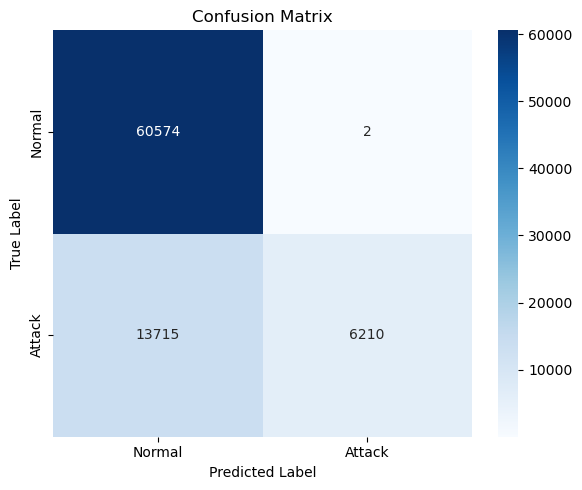

Evaluation time for dataset with 80501 items: 0.4986 seconds
Condition 1: 94
Condition 2: 0


In [22]:
def test(test_data, validated_tm, training_unique_ids):

    start_time = time.time() 


    condition_1 = 0
    condition_2 = 0

    test_data_ids = test_data['ID'].to_list()
    predicted_labels = []

    # print(f"Test data length {len(test_data_ids)}")

    for i in tqdm(range(len(test_data_ids) - 1)):
        
        # print(f"i: {i} i+1 : {i+1}")

        first_id = test_data_ids[i]
        second_id = test_data_ids[i+1]

        ## Check if both ids are in the transition matrix
        if (first_id in training_unique_ids) and (second_id in training_unique_ids):

            ##Check if transition is valid
            if validated_tm[first_id][training_unique_ids.index(second_id)]:
                predicted_labels.append(0)
            else: 
                predicted_labels.append(1)
                condition_1 += 1
                
        
        else:
            if first_id not in training_unique_ids:
                predicted_labels.append(1)
            else:
                predicted_labels.append(0)

        true_labels = test_data['label'].to_numpy()
    predicted_labels.append(0)
    predicted_labels = np.array(predicted_labels)

    # Print classification report
    print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Attack'], zero_division=0))

    # Compute confusion matrix: [[TN, FP], [FN, TP]]
    cm = confusion_matrix(true_labels, predicted_labels)
    TN, FP, FN, TP = cm.ravel()

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity, Recall
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
    fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
    tnr = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR / Recall): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"True Negative Rate (TNR / Specificity): {tnr:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    end_time = time.time()

    print("Evaluation time for dataset with {} items: {:.4f} seconds".format(len(test_data_ids), end_time - start_time))
    print(f"Condition 1: {condition_1}")
    print(f"Condition 2: {condition_2}")


test(attack_data, validated_ch_tm, ch_unique_ids)